# MSAIL Tutorial Series

## Classification

### Kaggle Intro and Outline

We will be working through the following [Kaggle competition](https://www.kaggle.com/c/titanic) to learn about various classification algorithms.

First we import the necessary libraries:
* pandas for parsing the csv file
* numpy for math and arrays
* scipy for more scientific computing
* matplotlib for generating visualizations

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import special

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

Read the training data into a pandas dataframe

In [28]:
df = pd.read_csv('train.csv', header=0)
print df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


Assign numerical values for gender

In [29]:
df['Gender'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

Clean the age data by replacing NaN with median given gender/class

In [30]:
median_ages = np.zeros((2, 3))
for i in range(0, 2):
    for j in range (0, 3):
        median_ages[i, j] = df[(df['Gender'] == i) & (df['Pclass'] == j+1)]['Age'].dropna().median()

df['AgeFill'] = df['Age']
        
for i in range(0, 2):
    for j in range(0, 3):
        df.loc[(df.Age.isnull()) & (df.Gender == i) & (df.Pclass == j+1), 'AgeFill'] = median_ages[i, j]

df['AgeIsNull'] = pd.isnull(df.Age).astype(int)

Construct the data matrix, x, using class, gender, and age, and ticket price. And split the data into train and test sets

In [31]:
x = np.array(df[['Pclass', 'Gender', 'AgeFill', 'Fare']])
y = np.array(df['Survived'])

num_train = 850

xtrain = x[0:num_train]
ytrain = y[0:num_train]

xtest = x[num_train:]
ytest = y[num_train:]

Define a function that:
* takes a model
* trains it
* uses it to perform classification on the test set

In [32]:
def train_and_test(model, xtrain, ytrain, xtest, ytest):
    model = model.fit(xtrain, ytrain)
    output = model.predict(xtest)
    print (1.0 * sum([i==j for (i, j) in zip(output, ytest)])) / len(ytest)

Define some classification models and get some results!

In [34]:
import sklearn.linear_model
model = sklearn.linear_model.LogisticRegression()
train_and_test(model, xtrain, ytrain, xtest, ytest)

0.780487804878


### Logistic Regression

Logistic regression is used for binary classification tasks. It processes a dataset $D = \{(x_1,t_1),\dots,(x_n,t_n)\}$, where $t_i\in\{0,1\}$ and the feature vector of the $i$th example is $\phi(x_i)\in\mathbb{R}^M$.

Logistic regression forms a probabilistic model. It estimates probability distributions of the two classes $p(t=1|x;w)$ and $p(t=0|x;w)$. It fits its paramaters $w\in\mathbb{R}^M$ to the training data by MLE, ie finds the $w$ that maximizes the probability of the training data.

__Logistic Model__

Given features for an example, $\phi(x)$, logistic regression models the probability of this example belonging to the class 1 as:

$$p(t=1|x;w) = \sigma(w^T\phi(x))$$

and defines the probability of the example belonging to the class 0 as:

$$
\begin{eqnarray}
p(t=0|x;w) &=& 1 - p(t=1|x;w) \nonumber\\
&=& 1 - \sigma(w^T\phi(x)) \nonumber
\end{eqnarray}
$$

where $\sigma(a)$ is the sigmoid function, which is defined as:

$$\sigma(a) = \frac{1}{1+e^{-a}}$$

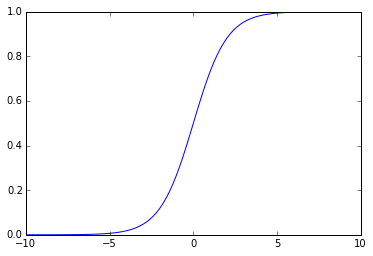

In [3]:
xaxis = np.arange(-10, 10, 0.2)
yaxis = sp.special.expit(xaxis)
plt.plot(xaxis, yaxis)

__Maximum Likelihood Estimation__

The likelihood function $L(w)$ is defined as the probability that the current $w$ assigns to the training set:

$$L(w) = \prod_{i=1}^Np(t_i|x_i;w)$$

We have two separate terms for the probability distributions of the two classes, so we combine these two terms into one like:

$$p(t_i|x_i;w) = p(t=1|x_i;w)^{t_i}p(t=0|x_i;w)^{1-t_i}$$

Logistic regression tries to find the $w$ that maximizes the likelihood $L(w)$, which is the same $w$ that maximizes the log-likelihood $l(w) = \log{L(w)}$.

$$
\begin{eqnarray}
\arg{\max{L(w)}} &=& \arg{\max{\log{L(w)}}} \nonumber\\
&=& \arg{\max{l(w)}} \nonumber\\
\nabla_wl(w) &=& \sum_{i=1}^{N}(t^i - \sigma(w^Tx_i))x^i \nonumber
\end{eqnarray}
$$

### SGD (Stochastic Gradient Descent)

We are currently calling scikit-learn's `.fit` method to train our model. Let us examine how this actually works.

<img src="https://upload.wikimedia.org/wikipedia/commons/f/ff/Gradient_descent.svg" height="200" width="200">

__Gradient descent/ascent__
* _descent_: find local minimum of function by taking steps proportional to the _negative_ of the gradient of the function at the current point
* _ascent_: find local maximum of function by taking steps proportional to the _positive_ of the gradient of the function at the current point

__Pseudocode__
```
n = learning rate
x = random
repeat
    x = x ± n * f'(x)
until convergence
return x
```

We repeatedly run through the training set and for each example, we update the parameters according to the gradient of the function with respect to that single example only.

### SVM (Support Vector Machine)

SVM is another discriminative model for classification. Although we are able to develop SVMs that do $K$ class classifications (similar to how logistic regression can be extended to multiclass classification ie softmax), we will restrict ourselves to binary classification in this formulation, where the class label is either +1 (positive) or -1 (negative). SVM is not a probabilistic algorithm; it does not optimize a probability measure as a likelihood, as we did in logistic regression. SVM tries to find the ***hyperplane that maximally separates the positive class from the negative class***.

<img src="https://upload.wikimedia.org/wikipedia/commons/b/b5/Svm_separating_hyperplanes_%28SVG%29.svg " height="200" width="200">

Let us now formulate the optimization problem for SVM. The decision boundry is the hyperplane $w^T\phi(x) + b = 0$. Now the linear discriminant function $y(x) = w^T\phi(x) + b$ with the maximum margin is a good classifier. Margin is the width that the boundry can be increased before hitting a data point. The maximum margin is good because this will be most robust to outliers and thus has strong generalization ability.

Remember the distance from a point $(x_1^*,x_2^*)$ to a line $a^Tx + b = 0$ in $\mathbb{R}^2$ is:
$$
\frac{a_1x_1^* + a_2x_2^* + b}{\sqrt{a_1^2 + a_2^2}}
$$

We can extend this for our maximum margin classifier so the distance from a $\phi(x)$ to the hyperplane $w^T\phi(x) + b = 0$ is:
$$
\frac{t(w^T\phi(x) + b)}{||w||}
$$

So now the margin is:
$$
\min_n\frac{t_n(w^T\phi(x_n) + b)}{||w||}
$$
where $n$ is the number of training examples.

Our optimization problem then becomes:
$$
\arg\max_{w,b}\frac{1}{||w||}\min_n[t_n(w^T\phi(x_n) + b)]
$$
which is saying that we would like to maximize the distance of the hyperplane from the closest "support vectors".

Now we can rescale $w$ and $b$ since the scaling factor will cancel when dividing by $||w||$. So, the support vectors will be along $w^T\phi(x) + b = \pm1$.
<img src="https://upload.wikimedia.org/wikipedia/commons/2/2a/Svm_max_sep_hyperplane_with_margin.png " height="200" width="200">

Our optimization problem then becomes:
$$
\begin{equation*}
\begin{aligned}
& \underset{w, b}{\text{minimize}}
& & \arg\min_{w,b}\frac{1}{2}||w||^2 \\
& \text{subject to}
& & t_n(w^T\phi(x_n) + b) \geq 1, \; n = 1, \ldots, N.
\end{aligned}
\end{equation*}
$$
since maximizing $\frac{1}{||w||}$ is the same as minimizing $||w||^2$, and the $\frac{1}{2}$ is for convenience.




Always cool to look up research papers!
http://research.microsoft.com/pubs/68541/dagsvm.pdf
This one is especially cool since mixing DAGs and SVMs is a great way for companies to assess a candidate's competency with both core algorithms as well as ML algos!

In [35]:
import sklearn.svm
model = sklearn.svm.SVC(kernel="rbf")
train_and_test(model, xtrain, ytrain, xtest, ytest)

0.731707317073


### Random Forests

In [36]:
import sklearn.ensemble
model = sklearn.ensemble.RandomForestClassifier(n_estimators=100)
train_and_test(model, xtrain, ytrain, xtest, ytest)

0.90243902439


In [37]:
import csv
df = pd.read_csv('test.csv', header=0)

df['Gender'] = df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

median_ages = np.zeros((2, 3))
for i in range(0, 2):
    for j in range (0, 3):
        median_ages[i, j] = df[(df['Gender'] == i) & (df['Pclass'] == j+1)]['Age'].dropna().median()

df['AgeFill'] = df['Age']
        
for i in range(0, 2):
    for j in range(0, 3):
        df.loc[(df.Age.isnull()) & (df.Gender == i) & (df.Pclass == j+1), 'AgeFill'] = median_ages[i, j]

df['AgeIsNull'] = pd.isnull(df.Age).astype(int)

data = np.array(df[['PassengerId', 'Pclass', 'Gender', 'AgeFill', 'Fare']])

with open("randomforestbasedmodel.csv", "wb") as pf:
    predictions = csv.writer(pf, delimiter=',')
    predictions.writerow(["PassengerId", "Survived"])
    for example in data:
        example = np.nan_to_num(example)
        predictions.writerow([str(example[0].astype(int)), str(model.predict(example[1:])[0])])